In [1]:
import pandas as pd
import json
import tweepy as tw
import configparser
import numpy as np
import re

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#Conexão com o MongoDb
from pymongo import MongoClient


## CONECTANDO AO config.ini

In [4]:
config = configparser.ConfigParser()
config.read("config.ini")

['config.ini']

## CONECTANDO AO BD ELEICOES2022

In [5]:
mongo = config["mongodb"]["mongo"]

In [6]:
#conectando ao mongoDB
client_db = MongoClient(mongo)

In [7]:
#Conectando ao banco de dados eleicoes2022
db = client_db.get_database("eleicoes2022_db")

In [63]:
#CONECTANDO AO COLLECTION NAME TWEETS
collection_tweets = db.tweets_

## CONECTANDO AO TWITTER

In [11]:
api_key = config["twitter"]["api_key"]
api_key_secret = config["twitter"]["api_key_secret"]
access_token = config["twitter"]["access_token"]
access_token_secret = config["twitter"]["access_token_secret"]

In [12]:
#Authentication
auth = tw.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth)

In [ ]:
# tw.Cursor(api.search_tweets)

In [ ]:
# #teste de conexão - home-timeline
# public_tweets = api.home_timeline()
# for tweet in public_tweets:
#     print(tweet.text)

## PESQUISANDO #ELEICOES2022

In [19]:
# search_words = "#Eleições2022"
query_words = "#Eleições2022 #Eleicoes2022" + "-filter:retweets" 

In [20]:
#Escolhendo tema especifico
tweets = tw.Cursor(api.search_tweets,
                    q = query_words).items(1000)

In [ ]:
# for tweet in tweets:
#     print(tweet.created_at)
#     print(tweet.text)

In [ ]:
# tweets_dict = {}
# tweets_dict = tweets_dict.fromkeys(tweet._json.keys())
# type(tweets_dict)

In [21]:
lista_tweets = []
for tweet in tweets:
    data = tweet._json
    tweets_dict = {key : value for key, value in data.items()}
    lista_tweets.append(tweets_dict)

In [22]:
#CRIANDO DF_TWEETS
df_tweets = pd.DataFrame.from_dict(lista_tweets)

In [23]:
df_tweets.shape

(838, 29)

In [24]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   created_at                 838 non-null    object 
 1   id                         838 non-null    int64  
 2   id_str                     838 non-null    object 
 3   text                       838 non-null    object 
 4   truncated                  838 non-null    bool   
 5   entities                   838 non-null    object 
 6   metadata                   838 non-null    object 
 7   source                     838 non-null    object 
 8   in_reply_to_status_id      100 non-null    float64
 9   in_reply_to_status_id_str  100 non-null    object 
 10  in_reply_to_user_id        109 non-null    float64
 11  in_reply_to_user_id_str    109 non-null    object 
 12  in_reply_to_screen_name    109 non-null    object 
 13  user                       838 non-null    object 

In [25]:
df_tweets.columns

Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status',
       'retweet_count', 'favorite_count', 'favorited', 'retweeted',
       'possibly_sensitive', 'lang', 'extended_entities', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status'],
      dtype='object')

In [26]:
#SELECIONANDO COLUNAS MAIS RELEVANTES
df_tweets_short = df_tweets[['created_at','text', 'truncated',
       'metadata', 'source', "user", 'retweet_count', 'retweeted', 'lang']]

In [27]:
#EXCLUINDO LINKS NA FEATURE TEXT
for idx, texto in enumerate(df_tweets_short["text"]):
    padrao = re.compile('https:.+')
    if padrao.findall(texto):
        https = padrao.findall(texto)
        df_tweets_short["text"][idx] = df_tweets_short["text"][idx].replace(https[0], "")

C:\Users\Usuário\AppData\Local\Temp\ipykernel_3476\1636851568.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_short["text"][idx] = df_tweets_short["text"][idx].replace(https[0], "")


In [28]:
pd.options.display.max_colwidth = 130
df_tweets_short["text"]

0       Teto de gastos ‘não é uma conspiração para desmontar a área social’. Leia a carta de Arminio Fraga, Edmar Bacha e P… 
1                                     E ainda tem gente dizendo que nada está acontecendo… #bolsonaro #Eleicoes2022 #Noticia 
2                                                                             #LulaPresidente2022 #Eleicoes2022 #informacion 
3                                                                                          Baba ovo do cacete! #Eleicoes2022 
4                     🗣No Egito Lula conversa com o mundo sobre Amazônia. No Brasil militares reencenam golpismo mumificado… 
                                                                ...                                                          
833       Esse é o maior tapa na cara que a sociedade pode levar!\n#barroso #lula #novayork #Eleicoes2022 #bolsonaro #brasil 
834             November 14th 2022\n2022年１１月１４日\nSalvador Bahia Brasil\n#ルラ　#ボウソナロ　#ブラジル大統領選　#Brazil \n#Brasil #Eleico

In [29]:
#CRIANDO FEATURE USUARIO
df_tweets_short["usuario"] = np.nan
for idx in df_tweets_short.index:
    df_tweets_short["usuario"][idx] = df_tweets_short["user"][idx]["screen_name"]

C:\Users\Usuário\AppData\Local\Temp\ipykernel_3476\3867158451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_short["usuario"] = np.nan
C:\Users\Usuário\AppData\Local\Temp\ipykernel_3476\3867158451.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_short["usuario"][idx] = df_tweets_short["user"][idx]["screen_name"]


In [30]:
#EXCLUINDO CARACTERES \n (caracter de quebra de linha)
for idx, texto in enumerate(df_tweets_short["text"]):
    df_tweets_short["text"][idx] =  texto.replace("\n", "")

C:\Users\Usuário\AppData\Local\Temp\ipykernel_3476\3296765182.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_short["text"][idx] =  texto.replace("\n", "")


In [31]:
df_tweets_short = df_tweets_short[['created_at','text', 'truncated',
       'metadata', 'source', 'retweet_count', 'retweeted', 'lang']]

## TRANSFORMAR JSON E SALVANDO NO BD

In [32]:
df_tweets_short.to_json("data/json_tweets.json", orient = "index")

In [33]:
with open('data/json_tweets.json') as f:
  json_tweets = json.load(f)

  collection_tweets.insert_many(json_tweets.values())

## IMPORTANDO JSON DO BD

In [37]:
tweets = pd.DataFrame(list(collection_tweets.find()))

In [41]:
tweets.head()

,_id,created_at,text,truncated,metadata,source,retweet_count,retweeted,lang
0,637664440188e2ffa271a2ed,Thu Nov 17 14:42:43 +0000 2022,"In Brazil And U.S., Elections As Stress Tests For Democracy#politics #brazil #UnitedStates #democracy #eleições…",True,"{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",0,False,en
1,637664440188e2ffa271a2ee,Thu Nov 17 14:42:42 +0000 2022,Continuamos na luta! #brazilwasstollen #Eleicoes2022,False,"{'iso_language_code': 'pt', 'result_type': 'recent'}","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",0,False,pt
2,637664440188e2ffa271a2ef,Thu Nov 17 14:36:46 +0000 2022,Veja a lista de 43 pessoas físicas e jurídicas suspeitas de financiar atos antidemocráticos (Piada pronta):.09 -…,True,"{'iso_language_code': 'pt', 'result_type': 'recent'}","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",0,False,pt
3,637664440188e2ffa271a2f0,Thu Nov 17 14:36:27 +0000 2022,É a política no Brasil tá como? #Politica #Brasil #Eleicoes2022 @iRodolffo te explica melhor 😂😂😂🧨🔫🖋️🔪💸🚜🥊🏹🍕🥩🍳🐀🐄,False,"{'iso_language_code': 'pt', 'result_type': 'recent'}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",0,False,pt
4,637664440188e2ffa271a2f1,Thu Nov 17 14:25:43 +0000 2022,@Seondetails #PERDEUMANÉ#LulaJá #LulaPresidente #Lula2022 #Lula#Eleições2022 #Eleiçoes22 #Brasil#FORABOLSONARO…,True,"{'iso_language_code': 'und', 'result_type': 'recent'}","<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",0,False,und


## CRIANDO NUVEM DE PALAVRAS

In [52]:
#Transformando o texto em uma unica string
string = pd.Series(tweets["text"].values).str.cat(sep = ' ')

In [53]:
# removendo caracteres especiais
caracteres = "#@"

for i in range(len(caracteres)):
    string = string.replace(caracteres[i], "")

In [54]:
#tranformando tudo em letra minuscula 
string = string.lower()

In [55]:
#criando stopwords
stopwords = set(STOPWORDS)
stopwords.update(["eleicoes2022", "eleições2022", "eleiçoes2022", "nem", "dia", "sua", "está", "por","de",'dar','pois','em','um','da','ser','aqui','vou','dos','ter','não','ao','sou','seu','à','n','se','esse','uma','mais','ele','fazendo','você','pode','essa','é','mas','segue','pra','isso','vez','para','muito','pelo','pela','são', 'na','vamos','https','t','co','c','New','eu','seis','retweets','ano','pessoa','likes', "nos", "já", "há", "até", "foi", "como", "quem", "cada","lá", "sem", 'vai','que','ou', "muita", "das", "bem", 'anos','7dias','tirou','tem','q','0','O','e','os','assim','só','mesmo','tá','pro','votar','pessoas','vc'])

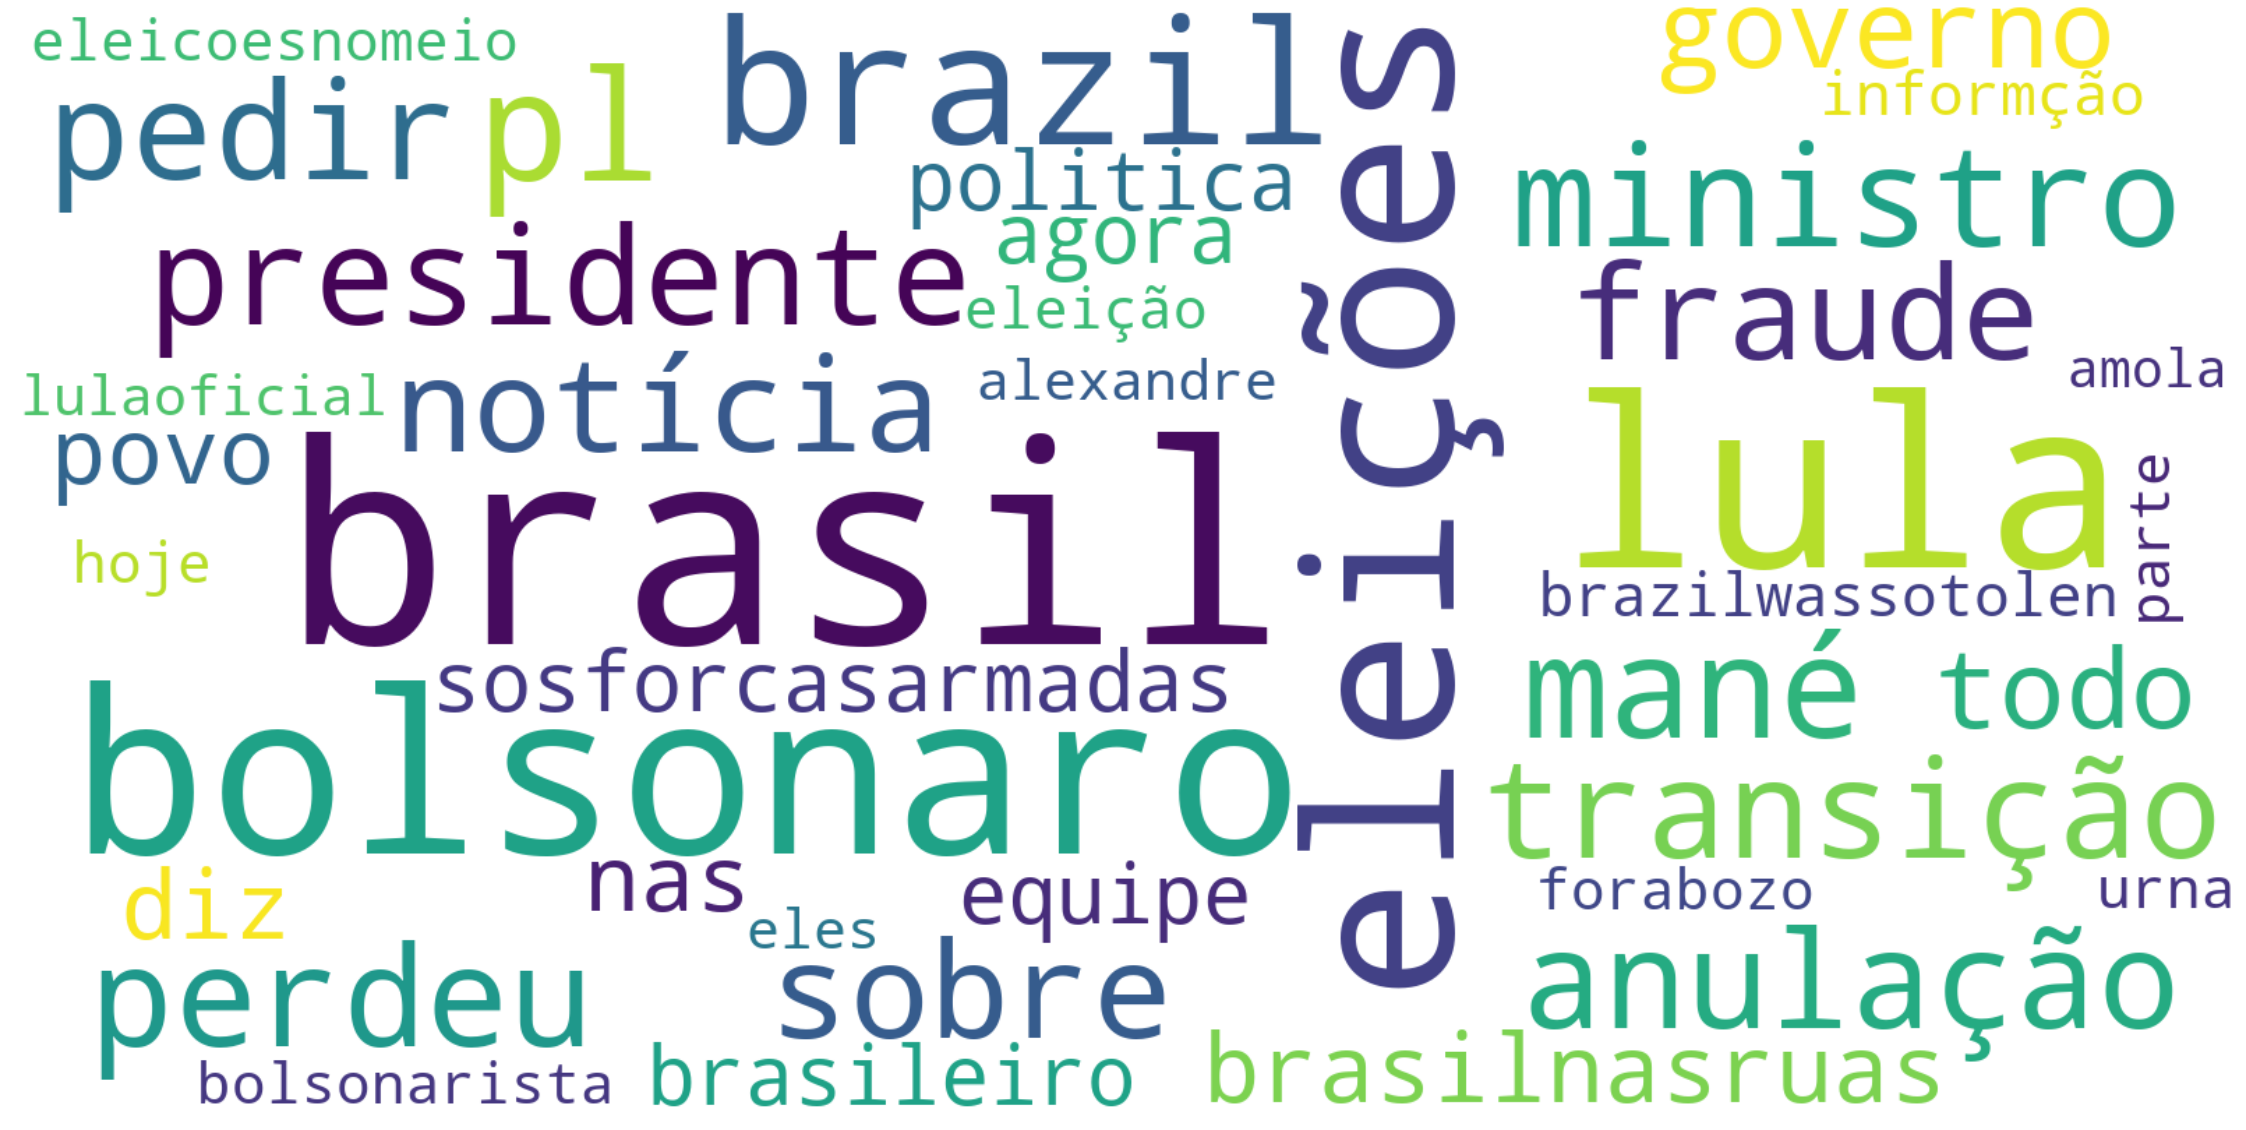

In [56]:
# Word Cloud com os textos dos tweets
wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800,max_font_size=200, max_words=40,collocations=False, background_color='white').generate(string)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()